# Sensor Data

The data that is used to test all database comes from a CSV file containing data obtained from an Ammonia sensor. This sensor measures the ammonia level at one minute interval.

The file that the sensors outputs to looks like:
```sh
Location;DBType;Channel;TimeUTC;Status;Quality;Value
;Raw;Ammonia;11/1/2017 2:20:00 PM;137;0;29.2063007354736
;Raw;Ammonia;11/1/2017 2:21:00 PM;137;0;29.3600006103516
;Raw;Ammonia;11/1/2017 2:22:00 PM;137;0;29.3605003356934
;Raw;Ammonia;11/1/2017 2:23:00 PM;137;0;29.5004997253418
```
The raw sensor data in this case contains approximately 260 000 data points. The script belows allows the user to specify the number of data points wanted from the raw sensor data. The number of datapoints that the user can specify can exceed the number of data points of the original file. This script allows the testing for the database size growth.



In [1]:
import time
import datetime
#Input a csv to make the desired number of lines

fpRead = "AmmoniaOne.csv"
fpWrite = "OneThousandEntries.csv"

fRead = open(fpRead,"r")
fWrite = open(fpWrite, "w")

numLines = len(open(fpRead).readlines())
delimiter = ';'
numOfData =1000 # number of datapoints wanted

numInserted = 0 # number of lines inserted

#Take desired amount of datapoints from input file
while ((numInserted < numLines-1) and (numInserted < numOfData)):
    fWrite.write(fRead.readline())
    numInserted +=1
saveLine = fRead.readline()
fWrite.write(saveLine)

#Make more datapoints when need more than available
if (numLines <= numOfData):
    saveLineSplit = saveLine.split(delimiter)
    timeString = saveLineSplit[3] #in this case on the third one change to make more general later
    format = "%m/%d/%Y %I:%M:%S %p"
    timeObject=datetime.datetime(*time.strptime(timeString, format)[:6])
    incrementTime= datetime.timedelta(0,0,0,0,1) # increment by 1 minute

    for i in range(numOfData-numLines+1):
            timeObject = timeObject + incrementTime
            saveLineSplit[3] = timeObject.strftime(format) #format and insert time into string
            fWrite.write(delimiter.join(saveLineSplit))


FileNotFoundError: [Errno 2] No such file or directory: 'AmmoniaOne.csv'

# InfluxDB


### Installation


####  Linux 4.4.6-gentoo 
*Used InfluxDB version 1.5.3-1

Open terminal and call the commands:
```sh

wget https://dl.influxdata.com/influxdb/releases/influxdb-1.5.3_linux_amd64.tar.gz

tar xvfz influxdb-1.5.3_linux_amd64.tar.gz
```
All the installation files will be located in a folder called `influxdb-1.5.3-1`. The installation size can be found by the command `du -sh influxdb-1.5.3-1`, which in this current build is 70 MB.

####  Raspbian (April 2018 Version) on Raspberry Pi 3 B+

*Used InfluxDB version 1.6.0

```sh

wget https://dl.influxdata.com/influxdb/releases/influxdb-1.6.0_linux_armhf.tar.gz

tar xvfz influxdb-1.6.0_linux_armhf.tar.gz

```




### Starting the Database

Start InfluxDB server.

```sh
~/influxdb-1.5.3-1/usr/bin $ ./influxd
```

InfluxDB provides a [command line tool](https://docs.influxdata.com/influxdb/v1.5/tools/shell/) which uses an SQL-like language. 

```sh
~/influxdb-1.5.3-1/usr/bin $ ./influx
```

### Database Size Growth

InfluxDB stores its data in a hidden folder called `.influxdb/data` in the user's home directory. Each database created is assigned a folder with the same name as the database, the size of a specific database can be found by calling the command `du -sh databaseName`.


| Number of Data Points  | Database Size |  
|---|---|
|  1 |  84 KB |
| 10 | 84 KB |
| 100 | 84 KB |
|1 000| 84 KB|
| 10 000| 92 KB  | 
|  100 000 | 180 KB  | 
| 1 000 000| 900 KB |
|10 000 000| 8.9 MB |
|100 000 000| 156 MB |

Note: When importing to the database especially one with large number of datapoints(starting after 10 Million Datapoints), you may get an error "too many files opened", this means that you need to [change the ulimit settings](https://github.com/influxdata/influxdb/issues/8618). 

This one was the one I used `ulimit -n 65536` (make sure you do this when you open the terminal for the importing and the one where InluxDB is currently running on. If it doesn't let you set a higher higher even though I have edited the file `/etc/security/limits.conf ` to add the line  `<username> hard nofile <number>` for my user, then reboot the machine for this to take effect.

To insert 100 000 000 points , I ran the script for about 2 hours.


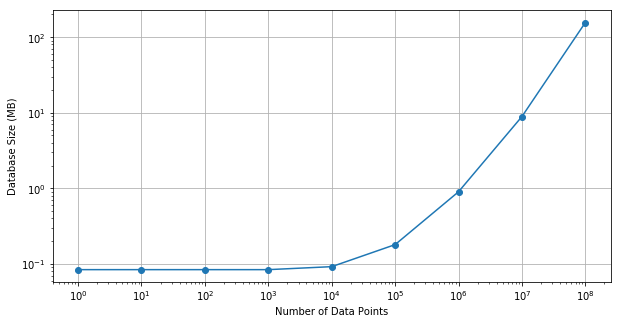

In [39]:
import matplotlib.pyplot as plt
import numpy as np

influx_x = np.array([10**i for i in range(9)])
influx_y = np.array([0.084,0.084,0.084,0.084,0.092,0.18,0.9,8.9,156 ]) # in MB (assumed 1000 KB ~= 1MB)

fig, ax = plt.subplots(figsize=(10, 5))
ax.loglog(influx_x, influx_y,"-o")


plt.xlabel('Number of Data Points')
plt.ylabel('Database Size (MB)')

ax.grid()


plt.show()

### Supported Data Types
[Documentation Source](https://docs.influxdata.com/influxdb/v1.5/write_protocols/line_protocol_reference/#main-nav)

|Type   | Length | Representation Range |
|---|---|---|
| Integer  |  64 bits  |  -9023372036854775808 to  9023372036854775807|
|  Float |  64 bits| ±2.23×10<sup>−308</sup> to ±1.80×10<sup>308</sup>( IEEE-754) |
|  String | 64 KB limit| Has support for [UNICODE](https://docs.influxdata.com/influxdb/v1.5/query_language/spec/#characters) |
| Boolean | 8 bits | t, T, true, True, TRUE or f, F, false, False, FALSE|
| Timestamps | 64 bits | 1677-09-21T00:12:43.145224194Z to 2262-04-11T23:47:16.854775806Z|

### Data Types Used

| Headers  | Type | Reason(s) |
|---|---|---|
|  Location | Untype   | The column has no value in it  |
|   DBType | String | Text  | 
|  Channel |  String | Text  |
| TimeUTC| Timestamp | This is their own [datatype](https://docs.influxdata.com/influxdb/v1.5/write_protocols/line_protocol_reference/#data-types). Stores unix nanoseconds timestamps |
| Status | Float| Default value numerical type|
| Quality | Float | Default value numerical type|
| Value |Float | Default value numerical type |

### Query Time
According to [InfluxDB's staff](https://community.influxdata.com/t/measure-query-execution-time/204), InfluxDB cannot directly report query timings. They recommded to measure using the linux command ` time influx -execute 'INFLUXDB COMMAND'`.

Another Method is to look at the HTTP request on Influxd, the last field indicated the time for that request in ms. This method is also one that is recommended by the Influx staff in the link above. I prefer this method because I think it is more accurate since the data is provided from InfluxDB themselves and not by a Linux clock.

Example of Getting Mean for Data 1 day (using second method):

On the Influx CLI insert:
```sh

use TenMillionEntries
select MEAN(*) from ammonia where time>=1509546000000000000 AND time<=1509546000000000000+1d

```
In this case `1509546000000000000` is the first entry in the database. To see results for other time ranges simply change the `1509546000000000000+1d`.


On `Influxd` the response is:

```sh

[httpd] ::1 - - [02/Aug/2018:12:13:05 +0000] "POST /query?chunked=true&db=TenMillionEntries&epoch=ns&q=select+MEAN%28%2A%29+from+ammonia+where+time%3E%3D1509546000000000000+AND+time%3C%3D1509546000000000000%2B1d HTTP/1.1" 200 158 "-" "InfluxDBShell/1.5.3" 68eeb9f5-964d-11e8-842a-000000000000 950

```

"950" is the time in microseconds to complete the query. Also, note the time are not exactly the same everytime it is executed, however the difference is minor (the most that I saw currently was a difference of ~50 microseconds)









### Python Import Script
The script belows imports the data obtained from sensors in CSV format to InfluxDB.

In [ ]:
import argparse
import csv
import sys
from datetime import datetime
from typing import Callable, Iterable, List

import influxdb


def insert_to_db(lines: Iterable[str], db: influxdb.InfluxDBClient, batch_size: int = None):
    assert batch_size is None or batch_size > 1, 'batch_size must be None or >1 but was %d' % batch_size
    done = object()

    line_iter = iter(lines)
    next(line_iter)
    batch = []
    while True:
        if len(batch) == batch_size:
            assert db.write(batch, params={'db': db._database}, protocol='line'), 'Failed to write to database'
            print("Wrote a batch of %d points" % batch_size )
            batch.clear()

        line = next(line_iter, done)
        if line is done:
            break
        batch.append(line)

    # Write the rest of the batch
    if len(batch) > 0:
        assert db.write(batch, params={'db': db._database}, protocol='line'), 'Failed to write to database'
        print("Wrote remaining %d points" % len(batch))


def create_converter(measurement: str, header: str) -> Callable[[List[str]], str]:
    formatters = []
    num_fields = 0

    #the comma delimiter here is for when you write in for --header
    for col in header.split(','):
        [typ, val] = col.split(':', 1)

        # the val=val in the lambda is a sad hack to capture the val in the current iteration in the function closure
        if typ == 'time':
            formatters.append(
                lambda s, fmt, val=val: fmt.__setitem__('time', int(datetime.strptime(s, val).timestamp() * 1e9)))
        elif typ == 'tag':
            formatters.append(lambda s, fmt, val=val: fmt.get('tags').append((val, s)))
        elif typ == 'field':
            num_fields += 1
            formatters.append(lambda s, fmt, val=val: fmt.get('fields').append((val, s)))
        else:
            formatters.append(lambda s, fmt: None)

    assert num_fields > 0, 'At least one field header is required.'

    def build_line(record: List[str]) -> str:
        formatted = {
            'time': None,  # nanoseconds since epoch
            'tags': [],
            'fields': []
        }

        for f, s in zip(formatters, record):
            try:
                f(s, formatted)
            except BaseException as e:
                print(e)
                pass

        line = measurement
        for tag in formatted['tags']:
            line += ',%s=%s' % tag
        fst = True
        for field in formatted['fields']:
            line += ' ' if fst else ','
            fst = False
            line += '%s=%s' % field
        if formatted['time'] is not None:
            line += ' %s' % formatted['time']

        return line

    return build_line


def main(argv):
    parser = argparse.ArgumentParser('influx-importer')
    parser.add_argument('--source', type=argparse.FileType('r'), default=sys.stdin,
                        help='The source csv file to import. The default is to read from stdin.')
    parser.add_argument('--batch', type=int, default=None,
                        help='The batch size for database writes. The default disables batched writes.')
    parser.add_argument('--delimiter', type=str, default=',',
                        help='The csv column separator. The default is ",".')

    parser.add_argument('--header', type=str, required=True,
                        help='Comma separated column correspondence with influx measurement parameters. '
                             '"time:<format>" for the timestamp column, "tag:<name>" and "field:<name>" for data '
                             'values. See also '
                             'https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior.'
                             'Ex: --header "time:%%m/%%d/%%Y %%I:%%M:%%S %%p,field:my-field,field:my-field2,unused:Location"')

    parser.add_argument('--host', type=str, required=False,
                        default='localhost',
                        help='hostname of InfluxDB http API')
    parser.add_argument('--port', type=int, required=False, default=8086,
                        help='port of InfluxDB http API')
    parser.add_argument('--database', type=str, required=True,
                        help='InfluxDB database name')
    parser.add_argument('--measurement', type=str, required=True,
                        help='InfluxDB measurement to insert the data into')

    args = parser.parse_args(argv)

    converter = create_converter(args.measurement, args.header)

    db_client = influxdb.InfluxDBClient(host=args.host, port=args.port, database=args.database)

    db_client.create_database(args.database)

    lines = map(converter, csv.reader(args.source, delimiter=args.delimiter))

    insert_to_db(lines, db_client, batch_size=args.batch)


if __name__ == '__main__':
    main(sys.argv[1:])


# ElasticSearch

### Installation

####  Linux 4.4.6-gentoo
*Tested with ElasticSearch-6.2.4

Ensure that you have at least Java 8 (1.8.X.X) otherwise install or upgrade first.
```sh
java -version
```

To download and install call the commands:

```sh
wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-6.2.4.tar.gz

wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-6.2.4.tar.gz.sha512

shasum -a 512 -c elasticsearch-6.2.4.tar.gz.sha512 

tar -xzf elasticsearch-6.2.4.tar.gz
```

Installation files will be located in the folder called `elasticsearch-6.2.4`. The size of the installation can be found by calling the command `du -sh elasticsearch-6.2.4`, which for this current build is 47 MB.

#### Raspbian (April 2018 Version) on Raspberry Pi 3 B+
*Tested with ElasticSearch-6.3.0

Ensure that you have at least Java 8 (1.8.X.X) otherwise install or upgrade first.
```sh
java -version
```

To download and install call the commands:
```sh
curl -L -O https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-6.3.0.tar.gz

tar -xvf elasticsearch-6.3.0.tar.gz
```

Edit the file `/elasticsearch-6.3.0/config/jvm.options`. Replace the [default](https://www.elastic.co/guide/en/elasticsearch/reference/master/heap-size.html) minimum and maximum heap size of 1GB(`-Xms1g` `-Xmx1g`) to 512MB (`-Xms512m` `-Xmx512m`). If this is not done, ElasticSearch will throw an error regarding insufficient memory for Java runtime enviroment.

Edit the file `/elasticsearch-6.3.0/config/elasticsearch.yml` by adding the line `xpack.ml.enabled: false`. This is done because Xpack and Machine Learning Libraries are not supported for the Linux-Arm.

### Starting the Database
Start ElasticSearch Server.

```sh
~/elasticsearch-6.2.4/bin $ ./elasticsearch
```
By default, this will start the server on `localhost:9200`.

To test that it is running successfully call the command `curl localhost:9200`, this should return the name of node running.

### Database Size Growth 
ElasticSearch stores its data in `~/elasticsearch-6.2.4/data/nodes/0/indices`. Each index (database) created has its own folder with their corresponding index number. Although a specific index size can be measured by looking at the size of the folder, it is difficult to tell which index number belongs to which index. ElasticSearch has a clean way of showing all its indices and size by calling the command `curl -XGET 'http://localhost:9200/_cat/indices?v'`.

| Number of Points  | Database Size |  
|---|---|
|  1 |  6.9 KB |
| 10 | 24.6 KB |
| 100 |  36.4 KB|
|1 000| 98.6 KB |
| 10 000| 702.3 KB  | 
|  100 000 | 5.4 MB | 
| 1 000 000| 37.7 MB |
| 10 000 000 ||
| 100 000 000| |


With the settings in the file `../elasticsearch-6.2.4/config/elasticsearch.yml` with the line shown below. I encountered an error when entering 10 Million Points and above, due to not having enough [memory allocated](https://www.elastic.co/guide/en/elasticsearch/reference/current/disk-allocator.html):

```sh

cluster.routing.allocation.disk.threshold_enabled: true
cluster.routing.allocation.disk.watermark.low: 95%
cluster.routing.allocation.disk.watermark.high: 93%

```

So I tried to change to change it to but the error still persists:

```sh

cluster.routing.allocation.disk.threshold_enabled: true
cluster.routing.allocation.disk.watermark.low: 100gb
cluster.routing.allocation.disk.watermark.high: 50gb
cluster.routing.allocation.disk.watermark.flood_stage: 10gb

```
Then I tried to disable the disk threshold all together, but the error still persists:
```sh
cluster.routing.allocation.disk.threshold_enabled: false

```


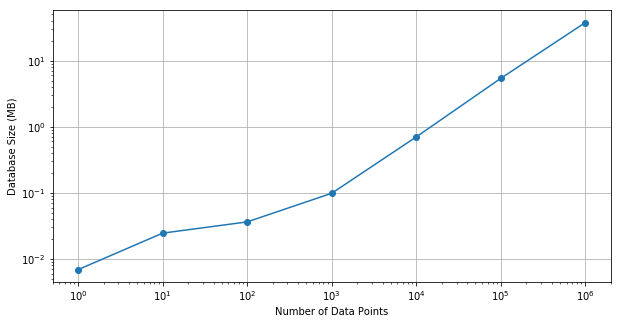

In [40]:
import matplotlib.pyplot as plt
import numpy as np

elastic_x = np.array([10**i for i in range(7)])
elastic_y = np.array([0.0069,0.0246,0.0364,0.0986,0.7023,5.4,37.7]) # in MB (assumed 1000 KB ~= 1MB)

fig, ax = plt.subplots(figsize=(10, 5))
ax.loglog(elastic_x, elastic_y,"-o")

plt.xlabel('Number of Data Points')
plt.ylabel('Database Size (MB)')

ax.grid()


plt.show()

### Supported Data Types
[Documentation](https://www.elastic.co/guide/en/elasticsearch/reference/current/mapping-types.html)
[Numeric Data Types](https://www.elastic.co/guide/en/elasticsearch/reference/6.x/number.html)

|Type   | Bit Length   | Representation Range |
|---|---|---|
|  Long |  64 bits |  -2<sup>63</sup> to 2<sup>63</sup>-1  |
|  Integer | 32 bits   |  2<sup>31</sup> to 2<sup>31</sup>-1 |
|  Short |  16 bits | -32 768 to 32 767   |
|  Byte |  8 bits |  -128 to 127 |
| Double |  64 bits | ±2.23×10<sup>−308</sup> to ±1.80×10<sup>308</sup>( IEEE-754)   |
| Float  | 32 bits  |  ±1.18×10<sup>−38</sup> to ±3.4×10<sup>38</sup>(IEEE-754)|
|  Half_float | 16 bits  |  -65,504 to 65,504 |
| Scaled float  | 128 bits  | Long that is fixed by double  |
|  Strings | No length limit  | Support for [UNICODE](https://www.elastic.co/guide/en/elasticsearch/guide/current/unicode-normalization.html)  |
|  Boolean |  8 bits |   true, "true" or false, "false"|




### Data Types Used

| Headers  | Type | Reason(s) |
|---|---|---|
|  Location | String   | Text  |
|   DBType| String | Text  | 
|  Channel | String  | Text |
| TimeUTC| *Long | Default for storing dates |
| Status | String | Text |
| Quality | String | Text |
| Value | **Float | Default for storing decimals  |

*When entering time it must be in ISO format, ElasticSearch will recognize this as a [date type](https://www.elastic.co/guide/en/elasticsearch/reference/current/mapping-types.html) and thus be searchable.

**Ensure that value is either an integer or float so that it will be graphable through Kibana(front-end)


### Python Import Script
The script belows imports the data obtained from sensors in CSV format to ElasticSearch.

In [ ]:
import time
import datetime
from elasticsearch import Elasticsearch
from elasticsearch import helpers

es = Elasticsearch() #the client

fpRead = "AmmoniaOne.csv"
fRead = open(fpRead,'r')
delimiter = ';'
format = "%m/%d/%Y %I:%M:%S %p" # time format
batchSize = 1000
actions = []
numLines = len(open(fpRead).readlines())
headers = (fRead.readline().rstrip()).split(delimiter)



for row in range (numLines - 1):
    doc = {} #elastic search document, set as a dictionary , must be put inside the loop
    values = (fRead.readline().rstrip()).split(delimiter)

    values[6] = float(values[6]) # this is the value that the sensor reads, CHANGE TO MAKE IT BE ABLE TO CHANGE COLUMN
    values[3] = datetime.datetime(*time.strptime(values[3], format)[:6]).isoformat() # must change to ISO make it searchable date on Kibana

    for column in range (len(headers)):
        doc[headers[column]] = values[column]
    action = {
                "_index" :"ammoniaone", #must be all lowercase
                "_type" : "sensorReadings", #document type
                "_id" : str(row+1),
                "_source" : doc
            }
    actions.append(action)

helpers.bulk(es, actions, chunk_size = batchSize) # according to ES website to try 1000-5000 but if large document then do smaller batches


# OpenTSDB


### Installation

#### HBase Installation

##### Linux 4.4.6-gentoo

Apache HBase must be installed first. Download `hbase-1.2.6.X-bin.tar.gz`from [here](http://apache.mirror.iweb.ca/hbase/stable/) or simply call the command `curl -L -O http://apache.mirror.iweb.ca/hbase/stable/hbase-1.2.6.X-bin.tar.gz`

Extract the package by calling the command:
```sh
tar xzvf hbase-1.2.6-bin.tar.gz
```
Edit the Hbase configuration file located in `~/hbase-1.2.6/conf/hbase-site.xml` and add the following lines provided from the [Apache Website](https://hbase.apache.org/book.html#_get_started_with_hbase). Change the `testuser` to the actual user name.

```sh 
<configuration>
  <property>
    <name>hbase.rootdir</name>
    <value>file:///home/testuser/hbase</value>
  </property>
  <property>
    <name>hbase.zookeeper.property.dataDir</name>
    <value>/home/testuser/zookeeper</value>
  </property>
  <property>
    <name>hbase.unsafe.stream.capability.enforce</name>
    <value>false</value>
    <description>
      Controls whether HBase will check for stream capabilities (hflush/hsync).

      Disable this if you intend to run on LocalFileSystem, denoted by a rootdir
      with the 'file://' scheme, but be mindful of the NOTE below.

      WARNING: Setting this to false blinds you to potential data loss and
      inconsistent system state in the event of process and/or node failures. If
      HBase is complaining of an inability to use hsync or hflush it's most
      likely not a false positive.
    </description>
  </property>
</configuration>
```
Set the `JAVA_HOME` environment variable by calling `JAVA_HOME=/usr`


Ensure that HBase is installed successfully and running before proceeding to install OpenTSDB. A good indicator of this can be done by starting HBase ` ~/hbase-1.2.6/bin/start-hbase.sh` and running the command `telnet localhost 2181` , then `stats`. If it shows a version of Zookeeper and its network statistics, therefore its installation was successful.

HBase's installation is stored in folder called `Hbase-1.2.6`, its size can be found by the command `du -sh Hbase-1.2.6` which for this current build is 544 MB.

##### Raspbian (April 2018 Version) on Raspberry Pi 3 B+
Follow the exact same steps, except setting the `JAVA_HOME` environment variable. In this case,go to the file `/hbase-1.2.6/conf/hbase-env.sh` and edit the corresponding line to become `export JAVA_HOME=/usr/lib/jvm/jdk-8-oracle-arm32-vfp-hflt`.

#### OpenTSDB Installation
Open terminal and run the commands:
```sh
git clone git://github.com/OpenTSDB/opentsdb.git

cd opentsdb

./build.sh
```
This command will create the 4 HBase table `tsdb`,`tsdb-meta`,`tsdb-tree` and `tsdb-uid` located in  `~/hbase/data/default` where it will store the databases' data.

```sh
env COMPRESSION=NONE HBASE_HOME=path/to/hbase-X.X.X ./src/create_table.sh
```

Configure OpenTSDB from the file `~/opentsdb/src/opentsdb.conf`. Change the respective lines to become:

```sh
tsd.network.port = 4242
tsd.http.staticroot = build/staticroot
tsd.http.cachedir = "$tsdtmp"
```

Its installation files are stored in a folder called `opentsdb`, its size can be found by the command `du -sh opentsdb` which for this current build is 190 MB.

##### For Raspberry Pi 3B+

Same steps, however before calling `/build.sh` you need to call `sudo apt-get install autoconf` first.

### Starting the Database

Start hbase and check if zookeeper is running. By default, zookeeper is running on port `2181`.

```sh 
~/hbase-1.2.6/bin $ ./start-hbase.sh
~/hbase-1.2.6/bin $ telnet localhost 2181
```

Start the OpenTSDB server.

```sh
~/opentsdb $ ./build/tsdb tsd --config=src/opentsdb.conf
```


### Database Size Growth

OpenTSDB uses HBase to store its data. Data from all metrics are stored into the four HBase table created during installation which are `tsdb`,`tsdb-meta`,`tsdb-tree` and `tsdb-uid` located in  `~/hbase/data/default`. This is consistent with their [documentation](http://opentsdb.net/docs/build/html/installation.html#create-tables).

Considering the fact that OpenTSDB does not have a delete metric(database) option and that all data are stored in the four HBase table mentioned earlier without any details regarding how each metric are stored, measuring the size while varying the amount of datapoints must be done with a clean copy of the tables **each time**. First, delete the folders `hbase`, `zookeeper` and `opentsdb/\"\$tsdtmp\"` , while HBase is off. Next, turn Hbase back on and run the command `env COMPRESSION=NONE HBASE_HOME=~/hbase-1.2.6 ~/opentsdb/src/create_table.sh` to create the four Hbase tables again. At this point, you can run the OpenTSDB server again and import the data. Then measure the total size of the four HBase tables by calling the command `du -sh *`.


| Number of Points  | Database Size |  
|---|---|
|  1 | 132 KB  |
| 10 | 132 KB|
| 100| 132 KB |
|1 000| 132 KB |
| 10 000| 132 KB   | 
|  100 000 |  132 KB | 
| 1 000 000| 43 MB|
| 10 000 000 ||
| 100 000 000||

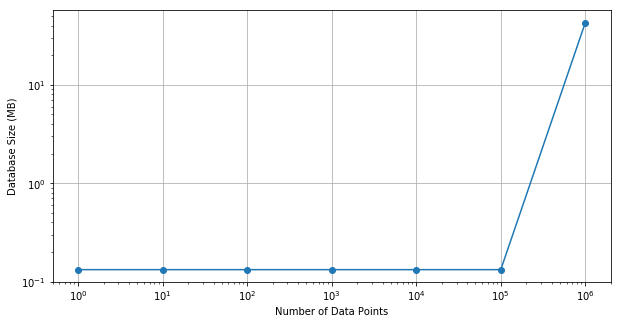

In [41]:
import matplotlib.pyplot as plt
import numpy as np

opent_x = np.array([10**i for i in range(7)])
opent_y = np.array([0.132,0.132,0.132,0.132,0.132,0.132,43]) # in MB (assumed 1000 KB ~= 1MB)

fig, ax = plt.subplots(figsize=(10, 5))
ax.loglog(opent_x, opent_y,"-o")

plt.xlabel('Number of Data Points')
plt.ylabel('Database Size (MB)')

ax.grid()


plt.show()

### Supported Data Types
[Documentation](http://opentsdb.net/docs/build/html/user_guide/writing.html)

|Type   | Bit Length   | Representation Range |
|---|---|---|
|  Integer | 8 bits to 64 bits(variable length)  |  -9,223,372,036,854,775,808 to 9,223,372,036,854,775,807 |
|  Floats |  32 bits |  ±1.18×10<sup>−38</sup> to ±3.4×10<sup>38</sup>(IEEE-754) |
|  Strings | No Length Limit  | Has support for [UNICODE](http://opentsdb.net/docs/build/html/user_guide/writing.html)|
|Timestamps| 16 bits or 32 bits| Depends if using seconds or milliseconds resolution|

### Data Types Used
[Documentation source](http://opentsdb.net/docs/build/html/api_http/put.html)

| Headers  | Type | Reason(s) |
|---|---|---|
|  Location | String  | Text  |
|   DBType| String  | Text  | 
|  Channel | String | Text  |
| TimeUTC| Integer | Default for storing unix timestamp|
| Status | Integer | *Default for storing number |
| Quality | Integer  | *Default for storing number |
| Value | Float | Default for storing decimal number |

*OpenTSDB automatically detects as a number


### Python Import Script
The script belows imports the data obtained from sensors in CSV format to OpenTSDB.

In [5]:
#Imports csv file to OpenTSDB
#client from https://github.com/scarchik/opentsdb-py

import time
import datetime
from opentsdb import TSDBClient


tsdb = TSDBClient(host="130.113.68.174") #using the ip address of the remote host in this case, still using default port of 4242

fpRead = "AmmoniaOne.csv"
fRead = open(fpRead,'r')
delimiter = ';'
format = "%m/%d/%Y %I:%M:%S %p" # time format
numLines = len(open(fpRead).readlines())
headers = (fRead.readline().rstrip()).split(delimiter)


for row in range (numLines - 1):
    values = (fRead.readline().rstrip()).split(delimiter)
    values[3]=datetime.datetime(*time.strptime(values[3], format)[:6]).timestamp() #convert time to UNIXTIME

    #ensuring that queue has enough space before loading more points
    while tsdb._metrics_queue.full():
        time.sleep(0.05)

    #have to manually name the tag, how to not do that
    #note: exclude location since it is nullstring it will cause error
    tsdb.send('test5', values[6], DBType=values[1], Channel = values[2], timestamp=values[3],Status=values[4],Quality = values[5])


tsdb.close()
tsdb.wait()


# Sqlite3

### Installation
Download the [sqlite package](https://www.sqlite.org/download.html) and extract. The installation size for Linux is 3.64 MB

### Starting the Database
By running the script below it will start automatically create and the database as well.


### Database Size Growth
Each database that is created by sqlite is in the form of a file with a `.db` extension. Its size can be found by the command `du -sh databaseName.db`.

| Number of Data Points  | Database Size |  
|---|---|
|  1 | 8 KB |
| 10|8 KB|
|100|16 KB|
|1 000| 64 KB|
| 10 000| 556 KB  | 
|  100 000 | 5 584 KB  | 
| 1 000 000| 56 460 KB |
|10 000 000||
|100 000 000||

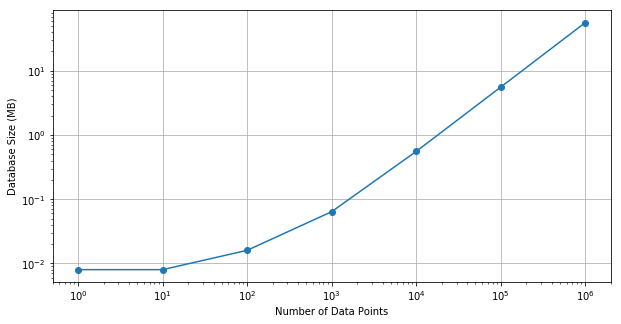

In [42]:
import matplotlib.pyplot as plt
import numpy as np

sqlite_x = np.array([10**i for i in range(7)])
sqlite_y = np.array([0.008,0.008,0.016,0.064,0.556,5.584,56.46]) # in MB (assumed 1000 KB ~= 1MB)

fig, ax = plt.subplots(figsize=(10, 5))
ax.loglog(sqlite_x, sqlite_y,"-o")

plt.xlabel('Number of Data Points')
plt.ylabel('Database Size (MB)')

ax.grid()


plt.show()

### Supported Data Types 
[Documentation Source](https://www.sqlite.org/datatype3.html)

|Type   | Bit Length   | Representation Range |
|---|---|---|
|  Null |  0 |   |
|  Integer | 8 bits to 64 bits (variable length)  |  -9,223,372,036,854,775,808 to 9,223,372,036,854,775,807 |
|  Real (floats) | 64 bits  |  ±2.23×10<sup>−308</sup> to ±1.80×10<sup>308</sup>( IEEE-754)  |
| Text(Strings)| No length limit | Support for [UNICODE](https://docs.python.org/2/library/sqlite3.html)|
| Boolean | 8 bits | Stored as integers as either 0 or 1|


### Datatypes Used

| Headers  | Type | Reason(s) |
|---|---|---|
|  Location | String  |  Text  |
|   DBType|  String  | Text  | 
|  Channel |  String  | Text  |
| TimeUTC| String | Text |
| Status | String | Text |
| Quality | String | Text |
| Value | Float | Default for storing decimals |



### Python Import Script
The script below will create a database and import data obtained from sensors in CSV format to Sqlite.

In [ ]:
import sqlite3

fpRead = "..\csvmaker\OneMillionEntries.csv" #input csv file
fRead = open(fpRead,'r')
delimiter = ';'
format = "%m/%d/%Y %I:%M:%S %p" # time format
numLines = len(open(fpRead).readlines()) # number of lines of the input file
headers = (fRead.readline().rstrip()).split(delimiter)

conn = sqlite3.connect('sqliteDBs\onemillionthousandentries.db') #client

c = conn.cursor()

# Create table
c.execute('''CREATE TABLE sensor_ph
             (Location text, DBType text, Channel text, TimeUTC text, Status text , Quality text, Value text)''') # headers of the csv file

for i in range(numLines - 1):
    values = (fRead.readline().rstrip()).split(delimiter)

    #Insert a row of data
    c.execute('''INSERT INTO sensor_ph (Location, DBType, Channel, TimeUTC, Status, Quality, Value)
                   VALUES(?,?,?,?,?,?,?)''', (values[0],values[1],values[2],values[3],values[4],values[5],values[6]))


# Save (commit) the changes
conn.commit()

# We can also close the connection if we are done with it.
# Just be sure any changes have been committed or they will be lost.
conn.close()
